# Tool Use and Conversational Chess

In [1]:
#Setup 
from dotenv import load_dotenv

import os

load_dotenv()
API_KEY = os.getenv("OPENAI_KEY")

In [31]:
llm_config = {"model": "gpt-4o-mini", "api_key": API_KEY}

On this implementation we will deploy 2 agents that will use an external tool to validate their chess moves

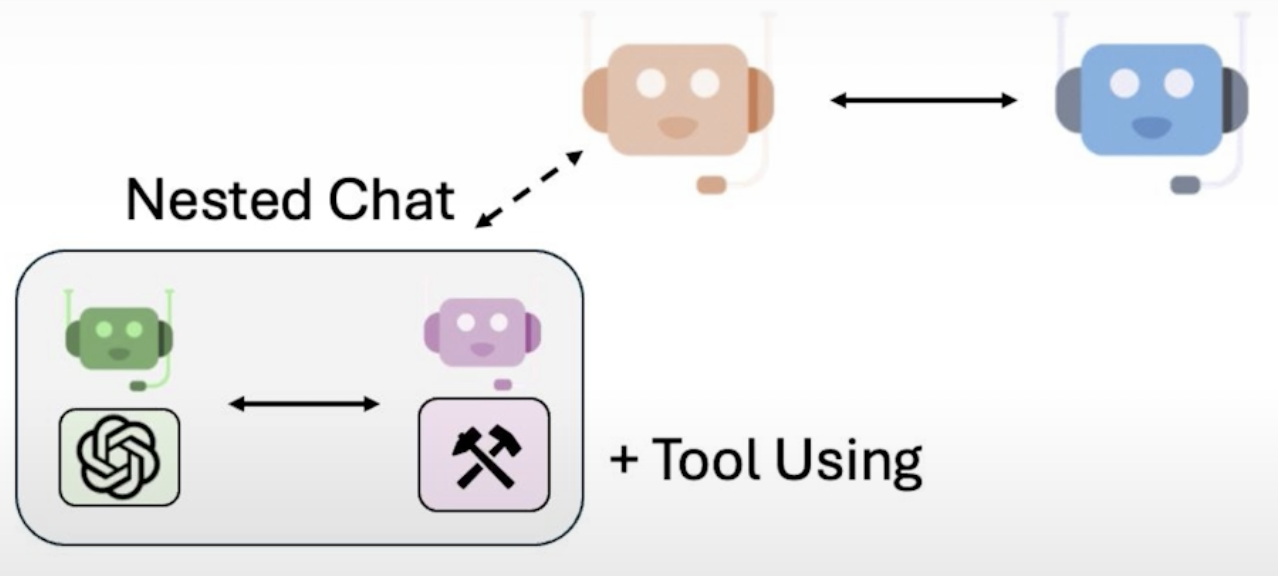

In [32]:
from IPython.display import Image
Image(filename='../assets/tool_using_1.png')


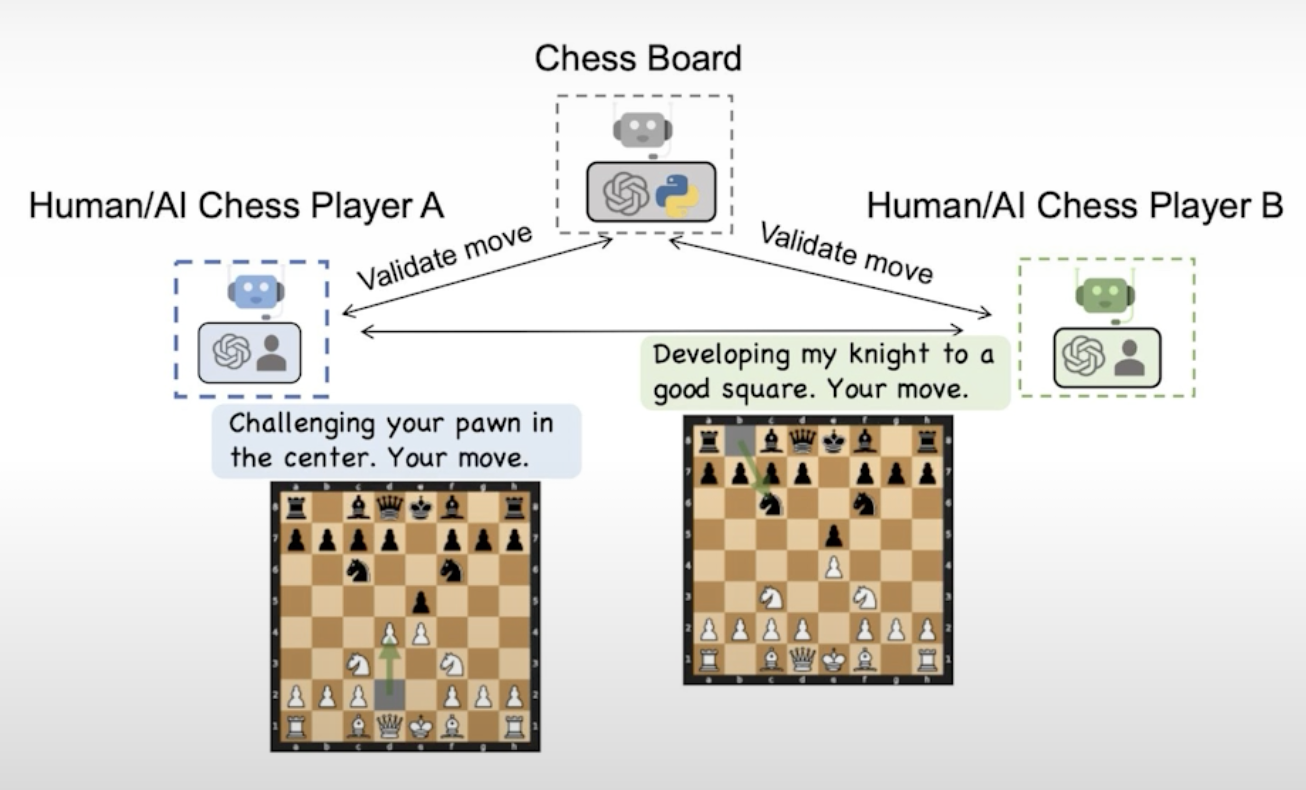

In [33]:
Image(filename='../assets/tool_using_2.png')

## Initialize the chess board

In [34]:
import chess
import chess.svg
from typing_extensions import Annotated

In [35]:
board = chess.Board()
made_move = False


Define tools for agents:

Get legal moves

In [36]:
def get_legal_moves(
# The Annotated class is used to provide type hints with additional context.
# Allow the Agent to understand the format of the returned content and the semantic meaning of the content.
) -> Annotated[str, "A list of legal moves in UCI format"]:
    return "Possible moves are: " + ",".join(
        [str(move) for move in board.legal_moves]
    )

In [37]:
def make_move(
    move: Annotated[str, "A move in UCI format."]
) -> Annotated[str, "Result of the move."]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True
    
    # Display the board.
    display(
        chess.svg.board(
            board,
            arrows=[(move.from_square, move.to_square)],
            fill={move.from_square: "gray"},
            size=200
        )
    )
    
    # Get the piece name. Get information of the move
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    return f"Moved {piece_name} ({piece_symbol}) from "\
    f"{chess.SQUARE_NAMES[move.from_square]} to "\
    f"{chess.SQUARE_NAMES[move.to_square]}."

Lets create the agents:

In [38]:
from autogen import ConversableAgent

In [39]:
# Player white agent
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [40]:
# Player black agent
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

Create another agent to check the moves with the players to the determine if the move is legal. For that we will need an stoping condition:

In [41]:
def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False

In [42]:
board_proxy = ConversableAgent(
    name="Board Proxy",
    llm_config=False, #No need to use LLMs
    is_termination_msg=check_made_move, # The agent will stop if a move has been made
    default_auto_reply="Please make a move.",
    human_input_mode="NEVER",
)

# Register the Tools

Tools need to be registered for the agent that executes the tool

In [43]:
from autogen import register_function
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )
    
    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

/Users/martinmoreno/Documents/proyects/autogen-agentic-design/.venv/lib/python3.11/site-packages/autogen/agentchat/conversable_agent.py:2408: UserWarning: Function 'get_legal_moves' is being overridden.
  warnings.warn(f"Function '{name}' is being overridden.", UserWarning)
/Users/martinmoreno/Documents/proyects/autogen-agentic-design/.venv/lib/python3.11/site-packages/autogen/agentchat/conversable_agent.py:2408: UserWarning: Function 'make_move' is being overridden.
  warnings.warn(f"Function '{name}' is being overridden.", UserWarning)


In [44]:
player_black.llm_config['tools']

[{'type': 'function',
  'function': {'description': 'Get legal moves.',
   'name': 'get_legal_moves',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}},
 {'type': 'function',
  'function': {'description': 'Call this tool to make a move.',
   'name': 'make_move',
   'parameters': {'type': 'object',
    'properties': {'move': {'type': 'string',
      'description': 'A move in UCI format.'}},
    'required': ['move']}}}]

# Register the nested chats:

Define nested chats from each agent with the board proxy agent:

In [45]:
#Before player white replays to player black, this nested chat will be initated until the the white player choose an approved move
player_white.register_nested_chats(
    trigger=player_black, # When a message is received from the black palyer the nested chat will be triggered
    # Nested chat will be perfomed before it will replay to the black player
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
        }
    ],
)

# Start the Game

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

***** Suggested tool call (call_Bfx4EhObv5fi97t82StBD7rP): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...


[runtime logging] log_function_use: autogen logger is None


Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_Bfx4EhObv5fi97t82StBD7rP) *****
Possible moves are: g1h3,g1f3,b1c3,b1a3,h2h3,g2g3,f2f3,e2e3,d2d3,c2c3,b2b3,a2a3,h2h4,g2g4,f2f4,e2e4,d2d4,c2c4,b2b4,a2a4
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

***** Suggested tool call (call_r6WU91e8S2VHekhqfiwxabTT): make_move *****
Arguments: 
{"move":"g1f3"}
**************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION make_move...


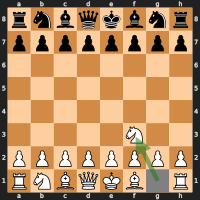

[runtime logging] log_function_use: autogen logger is None


Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_r6WU91e8S2VHekhqfiwxabTT) *****
Moved knight (♘) from g1 to f3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my knight from g1 to f3. Your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my knight from g1 to f3. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved my knight from g1 to f3. Your turn!

--------------------------------------

[runtime logging] log_function_use: autogen logger is None


Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_Ytk8LkDnk36afSRg7cbSQ3hr) *****
Possible moves are: g8h6,g8f6,b8c6,b8a6,h7h6,g7g6,f7f6,e7e6,d7d6,c7c6,b7b6,a7a6,h7h5,g7g5,f7f5,e7e5,d7d5,c7c5,b7b5,a7a5
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

***** Suggested tool call (call_yFc10KQIMOLeNpdXQjtH6UaK): make_move *****
Arguments: 
{"move":"g8f6"}
**************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION make_move...


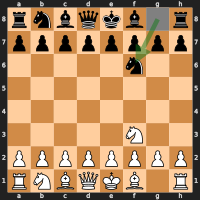

[runtime logging] log_function_use: autogen logger is None


Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_yFc10KQIMOLeNpdXQjtH6UaK) *****
Moved knight (♞) from g8 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I moved my knight from g8 to f6. Your turn!

--------------------------------------------------------------------------------
Player Black (to Player White):

I moved my knight from g8 to f6. Your turn!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I moved my knight from g8 to f6. Your turn!

--------------------------------------

[runtime logging] log_function_use: autogen logger is None


Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_va7nbQTv3aOkuAympOjWRGBE) *****
Possible moves are: f3g5,f3e5,f3h4,f3d4,f3g1,h1g1,b1c3,b1a3,h2h3,g2g3,e2e3,d2d3,c2c3,b2b3,a2a3,h2h4,g2g4,e2e4,d2d4,c2c4,b2b4,a2a4
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

***** Suggested tool call (call_8he4SGmEEeryygKRCoa7IXMp): make_move *****
Arguments: 
{"move":"f3g5"}
**************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION make_move...


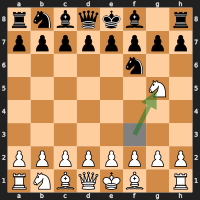

[runtime logging] log_function_use: autogen logger is None


Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_8he4SGmEEeryygKRCoa7IXMp) *****
Moved knight (♘) from f3 to g5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my knight from f3 to g5. Your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my knight from f3 to g5. Your turn!

--------------------------------------------------------------------------------


In [46]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=2,
)

# Add Chitchat to the game!

In [47]:
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [48]:
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [49]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )

    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
            "silent": True, # To not see the inner conversation
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...
[autogen.oai.client: 07-24 20:38:39] {315} WARNING - Model gpt-4o-mini-2024-07-18 is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.

>>>>>>>> EXECUTING FUNCTION get_legal_moves...


[runtime logging] log_function_use: autogen logger is None



>>>>>>>> USING AUTO REPLY...
[autogen.oai.client: 07-24 20:38:40] {315} WARNING - Model gpt-4o-mini-2024-07-18 is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.

>>>>>>>> EXECUTING FUNCTION make_move...


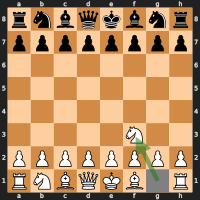

[runtime logging] log_function_use: autogen logger is None



>>>>>>>> USING AUTO REPLY...
[autogen.oai.client: 07-24 20:38:41] {315} WARNING - Model gpt-4o-mini-2024-07-18 is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
Player White (to Player Black):

I've moved my knight to f3! Your turn. Let's see what you've got up your sleeve. 🐴✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...
[autogen.oai.client: 07-24 20:38:44] {315} WARNING - Model gpt-4o-mini-2024-07-18 is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.

>>>>>>>> EXECUTING FUNCTION get_legal_moves...


[runtime logging] log_function_use: autogen logger is None



>>>>>>>> USING AUTO REPLY...
[autogen.oai.client: 07-24 20:38:45] {315} WARNING - Model gpt-4o-mini-2024-07-18 is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.

>>>>>>>> EXECUTING FUNCTION make_move...


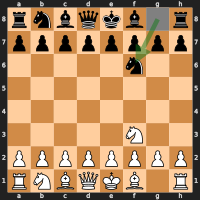

[runtime logging] log_function_use: autogen logger is None



>>>>>>>> USING AUTO REPLY...
[autogen.oai.client: 07-24 20:38:46] {315} WARNING - Model gpt-4o-mini-2024-07-18 is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
Player Black (to Player White):

I've moved my knight to f6! 🐴 Now I'm ready to defend and counter your knight with some flair. What's your next move? 😊

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...
[autogen.oai.client: 07-24 20:38:47] {315} WARNING - Model gpt-4o-mini-2024-07-18 is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.

>>>>>>>> EXECUTING FUNCTION get_legal_moves...


[runtime logging] log_function_use: autogen logger is None



>>>>>>>> USING AUTO REPLY...
[autogen.oai.client: 07-24 20:38:48] {315} WARNING - Model gpt-4o-mini-2024-07-18 is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.

>>>>>>>> EXECUTING FUNCTION make_move...


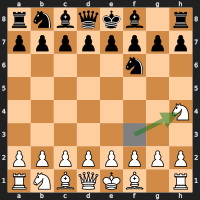

[runtime logging] log_function_use: autogen logger is None



>>>>>>>> USING AUTO REPLY...
[autogen.oai.client: 07-24 20:38:49] {315} WARNING - Model gpt-4o-mini-2024-07-18 is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
Player White (to Player Black):

I've just moved my knight to h4! 🐴 Looks like we're starting a knight party over here! Your turn! How will you respond to my playful knight? 😊✨

--------------------------------------------------------------------------------


In [50]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=2,
)